# **BitePulse AI - Label prep and task definition**



## **Introduction**

In this notebook let's turn EatSense data into clean training targets for our BitePulse AI model. so we'll define what counts as an intake event; convert frame level labels into segments with start time and end time; and freeze person disjoint splits for train, validation, and test. By the end, we will have compact label tables that downstream notebooks can load directly.

## **Data**

We'll utilize the data we saved on our google drive:

* Manifest file I created earlier
  * Path: /content/drive/MyDrive/eatsense/manifest_eatsense.csv
  * Purpose: join keys across modalities and keep everything aligned.

* 2D pose CSVs for training features and labels
  * Path: /content/drive/MyDrive/eatsense/poses_true

* RGB videos for quick visual checks only
  * Path: /content/drive/MyDrive/eatsense/rgb/deepfaked

I will not use depth in this notebook because my target app accepts user recorded RGB videos only. At inference time I can compute 2D poses from RGB, so training on 2D poses keeps training and deployment aligned.

## **Strategy**

* Load the manifest and pose CSVs; keep only the columns I need.
* Define intake versus not intake; create a simple binary flag.
* Merge frame labels into segments with start time and end time.
* Build one ground truth timeline plot per sample for a quick sanity check.
* Create train, validation, and test splits by participant; freeze and save them.

## **Imports and basic setup**

In [ ]:
# Mount Google Drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os, glob, json, re, random , time, hashlib
import re as regex
from pathlib import Path
from datetime import timedelta
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import Video, display
from typing import List, Optional
import cv2, subprocess, shlex




In [ ]:
# let's run below to customize notebook display:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 4000)

## **Paths setup**

Here's let's define our exact folders on Drive, then make sure they exist. I will also count a few files so I know the dataset is ready.

In [ ]:
# first let's set the root and key folders:
ROOT = Path("/content/drive/MyDrive/eatsense")
RGB_DIR = ROOT / "rgb" / "deepfaked"      # rgb videos for visual QA only
POSES_DIR = ROOT / "poses_true"           # choose poses_true
MANIFEST_CSV = ROOT / "manifest_eatsense.csv"

# alright now let's print the paths we're going to use:
print("ROOT:", ROOT)
print("RGB_DIR:", RGB_DIR)
print("POSES_DIR:", POSES_DIR)
print("MANIFEST_CSV:", MANIFEST_CSV)



ROOT: /content/drive/MyDrive/eatsense
RGB_DIR: /content/drive/MyDrive/eatsense/rgb/deepfaked
POSES_DIR: /content/drive/MyDrive/eatsense/poses_true
MANIFEST_CSV: /content/drive/MyDrive/eatsense/manifest_eatsense.csv


In [ ]:
# here I make sure the folders and manifest exist:
assert RGB_DIR.exists(), "rgb folder is missing"
assert POSES_DIR.exists(), "poses folder is missing"
assert MANIFEST_CSV.exists(), "manifest csv is missing"

# finally, quick counts check:
rgb_mp4 = sorted(glob.glob(str(RGB_DIR / "**" / "*.mp4"), recursive=True))
pose_csv = sorted(glob.glob(str(POSES_DIR / "**" / "*.csv"), recursive=True))

print("rgb videos count:", len(rgb_mp4))
print("pose csv count:", len(pose_csv))

rgb videos count: 135
pose csv count: 270


That's exactly what we expect: two pose files per video (True2D and True3D), so `135 x 2 = 270`.

In [ ]:
# show a couple of samples for peace of mind:
print("rgb sample:", rgb_mp4[:2])
print("pose sample:", pose_csv[:2])

rgb sample: ['/content/drive/MyDrive/eatsense/rgb/deepfaked/20210518_230219_anonymized.mp4', '/content/drive/MyDrive/eatsense/rgb/deepfaked/20210523_202300_anonymized.mp4']
pose sample: ['/content/drive/MyDrive/eatsense/poses_true/True2D/20210518_230219.mp4_preds_HigherHRNet.csv', '/content/drive/MyDrive/eatsense/poses_true/True2D/20210523_202300.mp4_preds_HigherHRNet.csv']


## **Pair videos with 2D poses**

Here, let's bring in the manifest I saved earlier, pull out the timestamp key, and pair every RGB video with its True2D pose CSV. This gives us a clean table to drive the rest of the notebook.

In [ ]:
# paths:
ROOT = "/content/drive/MyDrive/eatsense"
RGB_DIR   = f"{ROOT}/rgb/deepfaked"
TRUE_DIR  = f"{ROOT}/poses_true"

# timestamp key:
pat = re.compile(r"(\d{8}_\d{6})")
def key_from_path(p):
    m = pat.search(os.path.basename(p).lower())
    return m.group(1) if m else None

# collect files:
rgb   = glob.glob(os.path.join(RGB_DIR, "**", "*.mp4"), recursive=True)
true2d = glob.glob(os.path.join(TRUE_DIR, "True2D", "*.csv"))

# map by timestamp:
rgb_map   = {key_from_path(p): p for p in rgb   if key_from_path(p)}
true2d_map= {key_from_path(p): p for p in true2d if key_from_path(p)}

# intersect only what we need:
keys = sorted(set(rgb_map) & set(true2d_map))
print("rgb files:", len(rgb_map))
print("true2d files:", len(true2d_map))
print("paired keys (rgb + True2D):", len(keys))

# build the manifest:
rows = []
for k in keys:
    rows.append(dict(
        key=k,
        rgb=rgb_map[k],
        poses_true=true2d_map[k],
    ))

manifest_rgb_true2d = pd.DataFrame(rows).sort_values("key").reset_index(drop=True)
print("new manifest rows:", len(manifest_rgb_true2d))



rgb files: 135
true2d files: 135
paired keys (rgb + True2D): 135
new manifest rows: 135


In [ ]:
manifest_rgb_true2d.head(5)

,key,rgb,poses_true
0,20210518_230219,/content/drive/MyDrive/eatsense/rgb/deepfaked/20210518_230219_anonymized.mp4,/content/drive/MyDrive/eatsense/poses_true/True2D/20210518_230219.mp4_preds_HigherHRNet.csv
1,20210523_202300,/content/drive/MyDrive/eatsense/rgb/deepfaked/20210523_202300_anonymized.mp4,/content/drive/MyDrive/eatsense/poses_true/True2D/20210523_202300.mp4_preds_HigherHRNet.csv
2,20210529_150552,/content/drive/MyDrive/eatsense/rgb/deepfaked/20210529_150552_anonymized.mp4,/content/drive/MyDrive/eatsense/poses_true/True2D/20210529_150552.mp4_preds_HigherHRNet.csv
3,20210529_153708,/content/drive/MyDrive/eatsense/rgb/deepfaked/20210529_153708_anonymized.mp4,/content/drive/MyDrive/eatsense/poses_true/True2D/20210529_153708.mp4_preds_HigherHRNet.csv
4,20210530_153343,/content/drive/MyDrive/eatsense/rgb/deepfaked/20210530_153343_anonymized.mp4,/content/drive/MyDrive/eatsense/poses_true/True2D/20210530_153343.mp4_preds_HigherHRNet.csv


In [ ]:
# save alongside the old one so we keep both:
out_csv = f"{ROOT}/manifest_eatsense_rgb_true2d.csv"
manifest_rgb_true2d.to_csv(out_csv, index=False)
print("saved:", out_csv)

saved: /content/drive/MyDrive/eatsense/manifest_eatsense_rgb_true2d.csv


In [ ]:
# Alright let's do inspection:
# count how many rgb did NOT pair:
unpaired_rgb = sorted(set(rgb_map) - set(true2d_map))
print("rgb without 2D pose:", len(unpaired_rgb))
unpaired_rgb[:3]

# and how many 2D poses did NOT find a video:
unpaired_pose = sorted(set(true2d_map) - set(rgb_map))
print("2D pose without rgb:", len(unpaired_pose))
unpaired_pose[:3]


rgb without 2D pose: 0
2D pose without rgb: 0


[]

Alright let's switch away from `manifest_eatsense.csv` the one we saved from the first notebook because it contains only 133 RGB because we pair it initially with depth videos which has 133 only ... so now `manifest_eatsense_rgb_true2d.csv` is paired between RGB (deepfaked) with True2D only

In [ ]:
ROOT = Path("/content/drive/MyDrive/eatsense")
NEW_MANIFEST = ROOT / "manifest_eatsense_rgb_true2d.csv"
MANIFEST_CSV = NEW_MANIFEST

In [ ]:
# reload and peek:
manifest = pd.read_csv(MANIFEST_CSV)
print("manifest rows:", len(manifest))

manifest rows: 135


In [ ]:
manifest.head(3)

,key,rgb,poses_true
0,20210518_230219,/content/drive/MyDrive/eatsense/rgb/deepfaked/20210518_230219_anonymized.mp4,/content/drive/MyDrive/eatsense/poses_true/True2D/20210518_230219.mp4_preds_HigherHRNet.csv
1,20210523_202300,/content/drive/MyDrive/eatsense/rgb/deepfaked/20210523_202300_anonymized.mp4,/content/drive/MyDrive/eatsense/poses_true/True2D/20210523_202300.mp4_preds_HigherHRNet.csv
2,20210529_150552,/content/drive/MyDrive/eatsense/rgb/deepfaked/20210529_150552_anonymized.mp4,/content/drive/MyDrive/eatsense/poses_true/True2D/20210529_150552.mp4_preds_HigherHRNet.csv


## **True2D schema & loader**

Alright now, let's load one True2D CSV, peek at its schema, and lock a tiny loader that returns a clean table with frame, time_sec, and joint columns. I'll also detect joint names.

In [ ]:
# first let's grab one pose file from the new manifest:
manifest = pd.read_csv(MANIFEST_CSV)
assert "poses_true" in manifest.columns, "manifest must have poses_true"
SAMPLE_POSE = manifest.iloc[0]["poses_true"]
print("sample pose:", SAMPLE_POSE)

# alright now let's read a few rows to see the columns:
peek = pd.read_csv(SAMPLE_POSE, nrows=5)
print("cols:", list(peek.columns))
display(peek.head(3))


sample pose: /content/drive/MyDrive/eatsense/poses_true/True2D/20210518_230219.mp4_preds_HigherHRNet.csv
cols: ['path', 'imgName', 'head', 'Mid-Shoulder', 'Right-Shoulder', 'Right-Elbow', 'Right-Wrist', 'Left-shoulder', 'Left-Elbow', 'Left-Wrist', 'image_id', 'date', 'time', 'Action']


,path,imgName,head,Mid-Shoulder,Right-Shoulder,Right-Elbow,Right-Wrist,Left-shoulder,Left-Elbow,Left-Wrist,image_id,date,time,Action
0,./output_poses_orig//rgb/,0,"(122.54705, 103.8091)","(145.0617, 119.14211)","(102.9017, 123.658875)","(98.27272, 184.68211)","(104.75031, 241.81584)","(187.22173, 114.62535)","(212.22998, 168.66647)","(229.2968, 233.23466)",0,12/20/23,05:56:59,Pose Predictions
1,./output_poses_orig//rgb/,1,"(133.65022, 104.4981)","(156.7666, 120.09801)","(115.172745, 122.62478)","(110.87063, 182.1214)","(116.16045, 240.46733)","(198.36044, 117.571236)","(226.51405, 179.32426)","(239.54135, 237.89786)",1,12/20/23,05:56:59,Pose Predictions
2,./output_poses_orig//rgb/,2,"(148.52637, 105.30952)","(172.77614, 120.91492)","(132.83792, 121.55521)","(125.843636, 181.94485)","(128.05202, 239.33519)","(212.71436, 120.274635)","(239.09679, 182.81134)","(249.20326, 245.28015)",2,12/20/23,05:56:59,Pose Predictions


Alright as we can see above, Each joint column (like head, Mid-Shoulder, Right-Elbow, …) stores a string pair like `(122.55, 103.81)`, and also we have an image_id column that we can treat as the frame index.

EatSense docummnetation mentioned that the RGBD videos were captured at `15 FPS` so let's verify to make sure it's accurate for our data:

In [ ]:
def get_fps_ffprobe(path):
    try:
        cmd = f'ffprobe -v error -select_streams v:0 -show_entries stream=avg_frame_rate -of json "{path}"'
        out = subprocess.check_output(shlex.split(cmd)).decode()
        fr = json.loads(out)["streams"][0]["avg_frame_rate"]
        n, d = fr.split("/")
        n, d = float(n), float(d)
        return n / d if d else None
    except Exception:
        return None

def get_fps_cv2(path):
    try:
        cap = cv2.VideoCapture(path)
        fps = cap.get(cv2.CAP_PROP_FPS)
        cap.release()
        return float(fps) if fps and fps > 0 else None
    except Exception:
        return None

FPS_FALLBACK = 15.0

def get_fps(path):
    # try ffprobe first:
    fps = get_fps_ffprobe(path)
    if fps and fps > 0:
        return fps
    # then try OpenCV:
    fps = get_fps_cv2(path)
    if fps and fps > 0:
        return fps
    # final fallback:
    print(f"[warn] fps missing for {os.path.basename(path)} -> using {FPS_FALLBACK}")
    return FPS_FALLBACK



In [ ]:
sample_mp4s = sorted(glob.glob("/content/drive/MyDrive/eatsense/rgb/deepfaked/**/*.mp4", recursive=True))[:5]
for p in sample_mp4s:
    print(os.path.basename(p), "->", get_fps(p))


20210518_230219_anonymized.mp4 -> 15.0
20210523_202300_anonymized.mp4 -> 15.0
20210529_150552_anonymized.mp4 -> 15.0
20210529_153708_anonymized.mp4 -> 15.0
20210530_153343_anonymized.mp4 -> 15.0


Alright this is a confirmation, lso let's proceed with 15 fps.

In [ ]:
# cache path:
FPS_JSON = ROOT / "fps_by_key.json"

#  helpers:
def _get_fps_ffprobe(path):
    try:
        cmd = f'ffprobe -v error -select_streams v:0 -show_entries stream=avg_frame_rate -of json "{path}"'
        out = subprocess.check_output(shlex.split(cmd)).decode()
        fr = json.loads(out)["streams"][0]["avg_frame_rate"]
        n, d = fr.split("/")
        return float(n) / float(d)
    except Exception:
        return None

def _get_fps_cv2(path):
    try:
        cap = cv2.VideoCapture(path)
        fps = cap.get(cv2.CAP_PROP_FPS)
        cap.release()
        return float(fps) if fps and fps > 0 else None
    except Exception:
        return None

FPS_FALLBACK = 15.0

def get_fps(path):
    fps = _get_fps_ffprobe(path) or _get_fps_cv2(path)
    return fps if fps and fps > 0 else FPS_FALLBACK

# timestamp key extractor:
TS_PAT = re.compile(r"(\d{8}_\d{6})")
def ts_key(p):
    m = TS_PAT.search(os.path.basename(p));
    return m.group(1) if m else None

# load or compute:
if FPS_JSON.exists():
    fps_by_key = json.loads(FPS_JSON.read_text())
else:
    fps_by_key = {}

# fill only missing keys:
missing = []
for _, row in manifest.iterrows():
    key = ts_key(row["rgb"])
    if key and key not in fps_by_key:
        fps_by_key[key] = get_fps(row["rgb"])
        missing.append((key, fps_by_key[key]))

if missing:
    print(f"added {len(missing)} fps entries")
    FPS_JSON.write_text(json.dumps(fps_by_key, indent=2))

print("fps map size:", len(fps_by_key))
list(fps_by_key.items())[:3]


fps map size: 135


[('20210518_230219', 15.0),
 ('20210523_202300', 15.0),
 ('20210529_150552', 15.0)]

In [ ]:
# Alright now, True2D loader: parse "(x, y)" into floats:

PAIR_PAT = re.compile(r"\(?\s*([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)\s*[, ]\s*([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)\s*\)?")
def parse_xy(s):
    if isinstance(s, (list, tuple)) and len(s) == 2:
        return float(s[0]), float(s[1])
    if isinstance(s, str):
        m = PAIR_PAT.match(s)
        if m: return float(m.group(1)), float(m.group(2))
    return math.nan, math.nan

def load_true2d_with_fps(path, key, fps_map, default_fps=FPS_FALLBACK):
    df = pd.read_csv(path).copy()
    assert "image_id" in df.columns, "expected image_id in True2D CSV"
    df.rename(columns={"image_id": "frame"}, inplace=True)

    fps = float(fps_map.get(key, default_fps))
    df["time_sec"] = df["frame"] / fps

    meta = {"path", "imgName", "frame", "date", "time", "Action"}
    joints = [c for c in df.columns if c not in meta]
    for j in joints:
        xy = df[j].map(parse_xy)
        df[f"{j}_x"] = [p[0] for p in xy]
        df[f"{j}_y"] = [p[1] for p in xy]

    keep = ["frame", "time_sec"] + sum(([f"{j}_x", f"{j}_y"] for j in joints), [])
    return df[keep].reset_index(drop=True), joints



In [ ]:
row = manifest.iloc[0]
key = ts_key(row["rgb"])
pose_df, joints = load_true2d_with_fps(row["poses_true"], key, fps_by_key)

print("frames:", len(pose_df), "joints:", len(joints))
print("some joints:", joints[:8])
pose_df.head(3)

frames: 3668 joints: 9
some joints: ['head', 'Mid-Shoulder', 'Right-Shoulder', 'Right-Elbow', 'Right-Wrist', 'Left-shoulder', 'Left-Elbow', 'Left-Wrist']


,frame,time_sec,head_x,head_y,Mid-Shoulder_x,Mid-Shoulder_y,Right-Shoulder_x,Right-Shoulder_y,Right-Elbow_x,Right-Elbow_y,Right-Wrist_x,Right-Wrist_y,Left-shoulder_x,Left-shoulder_y,Left-Elbow_x,Left-Elbow_y,Left-Wrist_x,Left-Wrist_y,time_sec_x,time_sec_y
0,0,0.000000,122.54705,103.80910,145.06170,119.14211,102.901700,123.658875,98.272720,184.68211,104.75031,241.81584,187.22173,114.625350,212.22998,168.66647,229.29680,233.23466,NaN,NaN
1,1,0.066667,133.65022,104.49810,156.76660,120.09801,115.172745,122.624780,110.870630,182.12140,116.16045,240.46733,198.36044,117.571236,226.51405,179.32426,239.54135,237.89786,NaN,NaN
2,2,0.133333,148.52637,105.30952,172.77614,120.91492,132.837920,121.555210,125.843636,181.94485,128.05202,239.33519,212.71436,120.274635,239.09679,182.81134,249.20326,245.28015,NaN,NaN


In [ ]:
# here let's drop null columns:
pose_df = pose_df.loc[:, ~pose_df.columns.isin(["time_sec_x", "time_sec_y"])]



In [ ]:
pose_df.head(3)

,frame,time_sec,head_x,head_y,Mid-Shoulder_x,Mid-Shoulder_y,Right-Shoulder_x,Right-Shoulder_y,Right-Elbow_x,Right-Elbow_y,Right-Wrist_x,Right-Wrist_y,Left-shoulder_x,Left-shoulder_y,Left-Elbow_x,Left-Elbow_y,Left-Wrist_x,Left-Wrist_y
0,0,0.000000,122.54705,103.80910,145.06170,119.14211,102.901700,123.658875,98.272720,184.68211,104.75031,241.81584,187.22173,114.625350,212.22998,168.66647,229.29680,233.23466
1,1,0.066667,133.65022,104.49810,156.76660,120.09801,115.172745,122.624780,110.870630,182.12140,116.16045,240.46733,198.36044,117.571236,226.51405,179.32426,239.54135,237.89786
2,2,0.133333,148.52637,105.30952,172.77614,120.91492,132.837920,121.555210,125.843636,181.94485,128.05202,239.33519,212.71436,120.274635,239.09679,182.81134,249.20326,245.28015


In [ ]:
# Batch pre-process: cache tidy Parquet for speed:
OUT_PARQ = ROOT / "true2d_parquet"
OUT_PARQ.mkdir(parents=True, exist_ok=True)

written = 0
for i, row in manifest.iterrows():
    key = ts_key(row["rgb"])
    outp = OUT_PARQ / f"{key}.parquet"
    if outp.exists():
        continue
    df, joints = load_true2d_with_fps(row["poses_true"], key, fps_by_key)
    df.to_parquet(outp, index=False)
    written += 1

print("new parquet files written:", written)

new parquet files written: 0


In [ ]:
# fast loader: prefer Parquet, fallback to CSV+parser:
PARQ_DIR = ROOT / "true2d_parquet"

def load_true2d_by_key(key: str):
    p = PARQ_DIR / f"{key}.parquet"
    if p.exists():
        return pd.read_parquet(p)
    # fallback (rare) – parse CSV then cache:
    row = manifest.loc[manifest["key"] == key].iloc[0]
    df = load_true2d_pairwise_csv_with_fps(row["poses_true"], key, fps_by_key, default_fps=FPS_FALLBACK)
    return df


In [ ]:
#Sanity check:
have = sum((OUT_PARQ / f"{ts_key(r['rgb'])}.parquet").exists() for _, r in manifest.iterrows())
print(f"parquet coverage: {have}/{len(manifest)}")

parquet coverage: 135/135


In [ ]:
df0 = load_true2d_by_key(manifest.iloc[0]["key"])
df0.head(3)

,frame,time_sec,head_x,head_y,Mid-Shoulder_x,Mid-Shoulder_y,Right-Shoulder_x,Right-Shoulder_y,Right-Elbow_x,Right-Elbow_y,Right-Wrist_x,Right-Wrist_y,Left-shoulder_x,Left-shoulder_y,Left-Elbow_x,Left-Elbow_y,Left-Wrist_x,Left-Wrist_y,time_sec_x,time_sec_y
0,0,0.000000,122.54705,103.80910,145.06170,119.14211,102.901700,123.658875,98.272720,184.68211,104.75031,241.81584,187.22173,114.625350,212.22998,168.66647,229.29680,233.23466,NaN,NaN
1,1,0.066667,133.65022,104.49810,156.76660,120.09801,115.172745,122.624780,110.870630,182.12140,116.16045,240.46733,198.36044,117.571236,226.51405,179.32426,239.54135,237.89786,NaN,NaN
2,2,0.133333,148.52637,105.30952,172.77614,120.91492,132.837920,121.555210,125.843636,181.94485,128.05202,239.33519,212.71436,120.274635,239.09679,182.81134,249.20326,245.28015,NaN,NaN


### **Quick visual sanity check**

wrist paths and simple signals. I just want make sure joints move sensibly over time and that time_sec aligns with frames.

In [ ]:
# pick a sample video:
row  = manifest.iloc[0]
key  = re.search(r"(\d{8}_\d{6})", os.path.basename(row["rgb"])).group(1)

pose_df, JOINTS = load_true2d_with_fps(row["poses_true"], key, fps_by_key)

print("video key:", key)
print("frames:", len(pose_df), " seconds:", pose_df["time_sec"].iloc[-1])

pose_df.head(3)


video key: 20210518_230219
frames: 3668  seconds: 244.46666666666667


,frame,time_sec,head_x,head_y,Mid-Shoulder_x,Mid-Shoulder_y,Right-Shoulder_x,Right-Shoulder_y,Right-Elbow_x,Right-Elbow_y,Right-Wrist_x,Right-Wrist_y,Left-shoulder_x,Left-shoulder_y,Left-Elbow_x,Left-Elbow_y,Left-Wrist_x,Left-Wrist_y,time_sec_x,time_sec_y
0,0,0.000000,122.54705,103.80910,145.06170,119.14211,102.901700,123.658875,98.272720,184.68211,104.75031,241.81584,187.22173,114.625350,212.22998,168.66647,229.29680,233.23466,NaN,NaN
1,1,0.066667,133.65022,104.49810,156.76660,120.09801,115.172745,122.624780,110.870630,182.12140,116.16045,240.46733,198.36044,117.571236,226.51405,179.32426,239.54135,237.89786,NaN,NaN
2,2,0.133333,148.52637,105.30952,172.77614,120.91492,132.837920,121.555210,125.843636,181.94485,128.05202,239.33519,212.71436,120.274635,239.09679,182.81134,249.20326,245.28015,NaN,NaN


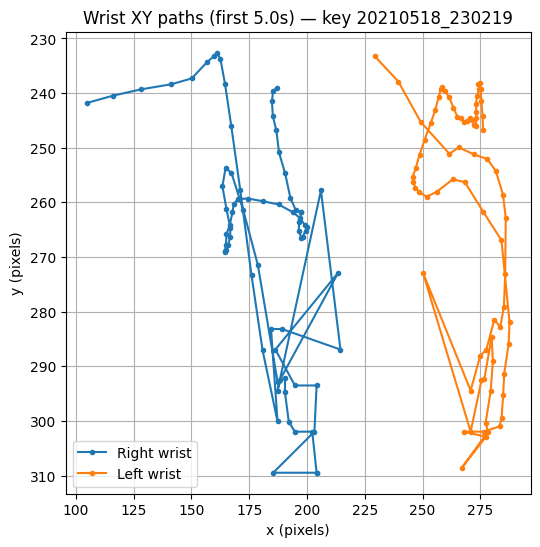

In [ ]:
# let's take first 5 seconds:
t0, t1 = 0.0, 5.0
win = pose_df.query("@t0 <= time_sec <= @t1").reset_index(drop=True)

# grab wrists:
rx, ry = win["Right-Wrist_x"].to_numpy(), win["Right-Wrist_y"].to_numpy()
lx, ly = win["Left-Wrist_x"].to_numpy(),  win["Left-Wrist_y"].to_numpy()

# plot:
plt.figure(figsize=(6,6))
plt.plot(rx, ry, marker=".", label="Right wrist")
plt.plot(lx, ly, marker=".", label="Left wrist")
plt.gca().invert_yaxis()   # image y goes downward; invert for intuitive viewing
plt.title(f"Wrist XY paths (first {t1-t0:.1f}s) — key {key}")
plt.xlabel("x (pixels)")
plt.ylabel("y (pixels)")
plt.legend()
plt.grid(True)
plt.show()


**Summary Highlights:**

* As shown above, the 2D trajectories of the right (blue) and left (orange) wrists.
* Going down the plot means the hand moved downward in the video frame (y grows downward).
* Right wrist (blue): a long, mostly downward-and-back arc with a few sharp kinks. That pattern looks like the hand leaving the table/plate area, moving up toward the face, then returning; classic "bring to mouth" motion with a couple of micro-corrections mid-path.
* Left wrist (orange): tighter loops and a smaller workspace, staying more to the side. It's likely playing a stabilizing/support role (e.g., holding a cup/plate) while the right hand does the primary movement.
* Separation of clusters: distinct path segments rather than a cloud, implying discrete actions rather than random fidgeting.

In [ ]:
def speed_xy(x, y, t):
    # simple finite difference speed (pixels/second):
    dx = np.diff(x, prepend=x[:1])
    dy = np.diff(y, prepend=y[:1])
    dt = np.diff(t, prepend=t[:1])
    dt = np.where(dt==0, 1e-6, dt)
    return np.sqrt(dx*dx + dy*dy) / dt

def angle_deg(ax, ay, bx, by, cx, cy):
    # angle at point B formed by A-B-C:
    # returns degrees in [0, 180]:
    BA = np.stack([ax-bx, ay-by], axis=1)
    BC = np.stack([cx-bx, cy-by], axis=1)
    num = np.sum(BA*BC, axis=1)
    den = np.linalg.norm(BA, axis=1)*np.linalg.norm(BC, axis=1) + 1e-6
    cos = np.clip(num/den, -1.0, 1.0)
    return np.degrees(np.arccos(cos))

# compute signals on the same window:
t  = win["time_sec"].to_numpy()

r_wrist_speed = speed_xy(win["Right-Wrist_x"], win["Right-Wrist_y"], t)
l_wrist_speed = speed_xy(win["Left-Wrist_x"],  win["Left-Wrist_y"],  t)

r_elbow_angle = angle_deg(win["Right-Shoulder_x"], win["Right-Shoulder_y"],
                          win["Right-Elbow_x"],    win["Right-Elbow_y"],
                          win["Right-Wrist_x"],    win["Right-Wrist_y"])

l_elbow_angle = angle_deg(win["Left-shoulder_x"], win["Left-shoulder_y"],
                          win["Left-Elbow_x"],    win["Left-Elbow_y"],
                          win["Left-Wrist_x"],    win["Left-Wrist_y"])


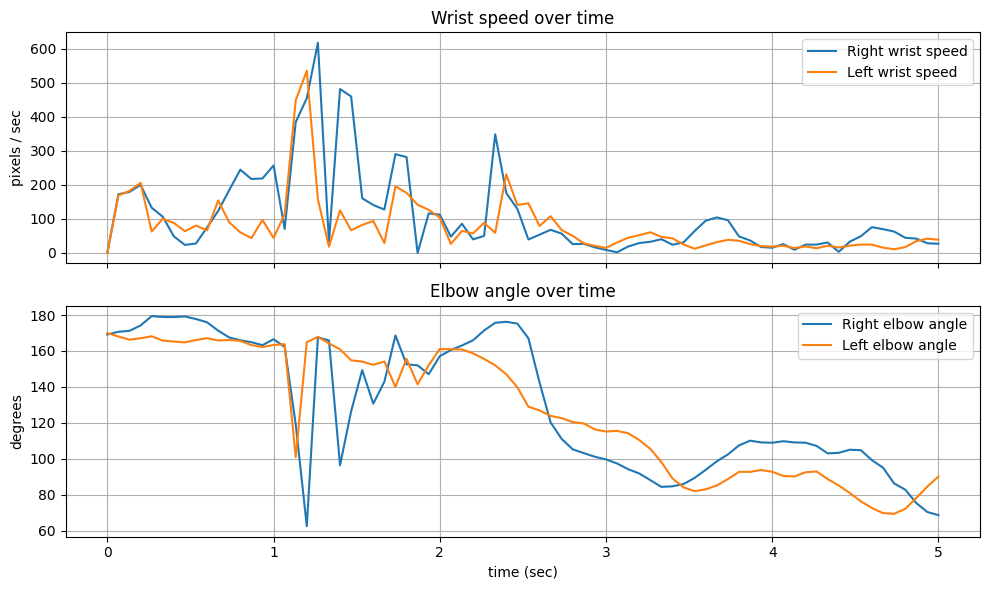

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10,6), sharex=True)

axes[0].plot(t, r_wrist_speed, label="Right wrist speed")
axes[0].plot(t, l_wrist_speed, label="Left wrist speed")
axes[0].set_ylabel("pixels / sec")
axes[0].set_title("Wrist speed over time")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(t, r_elbow_angle, label="Right elbow angle")
axes[1].plot(t, l_elbow_angle, label="Left elbow angle")
axes[1].set_ylabel("degrees")
axes[1].set_xlabel("time (sec)")
axes[1].set_title("Elbow angle over time")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


**Summary Highlights: (Top) Wrist speed (pixels/sec)**

* Blue spikes &asymp; right wrist bursts. We have strong peaks around ~1.-.6 s and ~2.2 s (and smaller activity around ~4.-.6 s). Those are short, high-velocity phases typical of transport-to-mouth or utensil pickup/put-down.

* Orange (left wrist) is calmer, with smaller peaks that often trail or coincide with the right wrist, suggesting assisting rather than leading.

**Summary Highlights: Elbow angle (degrees; larger = straighter arm)**

* Both elbows start near ~ 165-175 &deg; (pretty straight) and drop sharply during the first right-wrist speed burst (~1.2-1.6 s). That drop to ~100-120° is elbow flexion consistent with bringing food/drink to the mouth.

* A second flexion cycle follows around ~2.0-2.5 s, again aligned with a right-wrist speed pulse. Later, there's a broader, slower flexion into the ~80-95 &deg; range around ~3.4-3.8 s, then recovery; another intake-like segment but less ballistic.

* Synchronization: The clearest intake candidates are where right-wrist speed spikes line up with elbow-angle minima. We have that coupling multiple times in the first ~3 seconds.

In [ ]:
# Path to our parquet file:
POSE_FEATS_PATH = Path("/content/drive/MyDrive/eatsense/windows/pose_feats.parquet")

pose_feats = pd.read_parquet(POSE_FEATS_PATH)
print("pose_feats shape:", pose_feats.shape)
pose_feats.head()

pose_feats shape: (98582, 18)


,key,split,win_id,start_sec,end_sec,label,rw_speed_mean,rw_speed_max,rw_head_min,rw_path,lw_speed_mean,lw_speed_max,lw_head_min,lw_path,re_angle_mean,re_angle_std,le_angle_mean,le_angle_std
0,20210518_230219,train,0,0.0,2.0,0,145.005528,292.955069,16.572304,388.575546,93.775873,240.865456,20.674800,254.556086,156.609365,26.183085,159.404531,13.165441
1,20210518_230219,train,1,0.5,2.5,0,144.750844,292.955069,16.572304,395.191243,86.067394,240.865456,20.674800,242.444187,154.726599,25.178434,156.092829,12.925139
2,20210518_230219,train,2,1.0,3.0,0,115.429775,292.955069,16.572304,326.245907,84.059480,240.865456,20.674800,238.720912,143.522549,28.808757,146.182834,17.691644
3,20210518_230219,train,3,1.5,3.5,0,70.348694,261.323483,44.639644,161.334968,65.090198,173.324211,70.185487,156.761878,132.174230,32.609472,132.567564,22.362200
4,20210518_230219,train,4,2.0,4.0,0,59.101835,261.323483,77.260761,120.857773,55.453864,173.324211,67.433284,111.393292,121.100324,32.854782,118.182391,26.003087


In [ ]:
cols_needed = ["key", "start_sec", "end_sec", "label", "split"]

windows_df = (
    pose_feats[cols_needed]
    .drop_duplicates()
    .reset_index(drop=True)
)

print("windows_df shape:", windows_df.shape)

windows_df["split"].value_counts()

windows_df shape: (98582, 5)


,count
split,
train,62568
val,21184
test,14830


2D file : /content/drive/MyDrive/eatsense/poses_true/True2D/20210518_230219.mp4_preds_HigherHRNet.csv
3D file : /content/drive/MyDrive/eatsense/poses_true/True3D/20210518_230219.csv
2D frames: 3668  3D frames: 3668
Frames used: 3668, duration ≈ 244.5 sec
20210518_230219: found 65 action segments


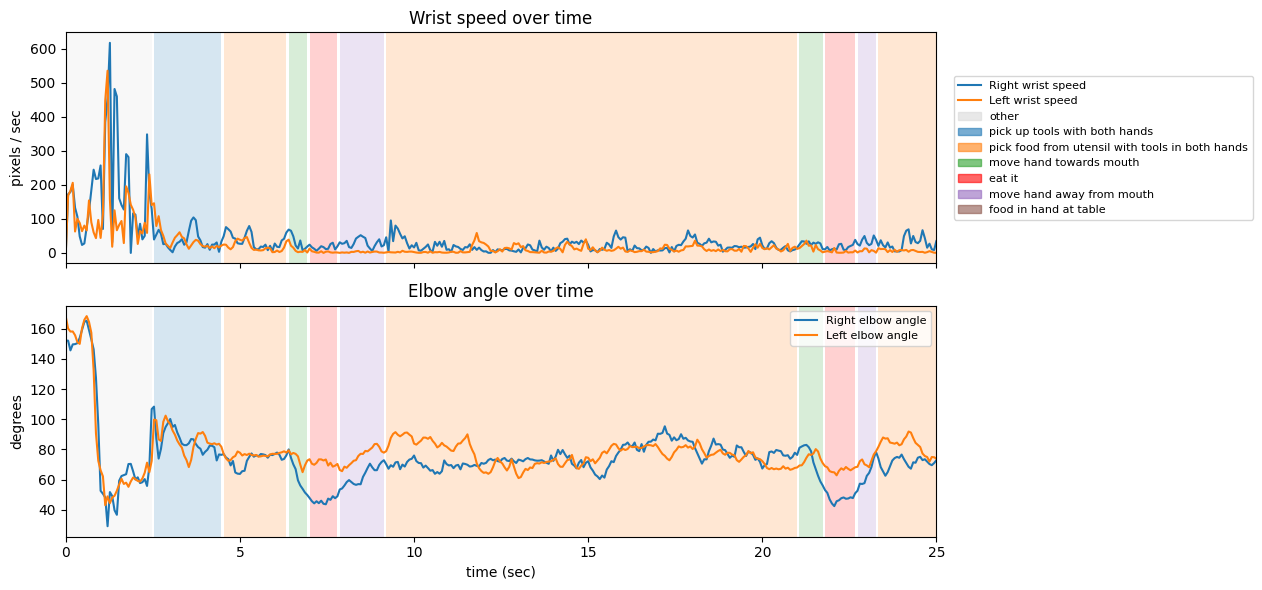

In [ ]:
# Paths & basic config:

demo_key = "20210518_230219"
FPS_POSE = 15.0

ROOT = Path("/content/drive/MyDrive/eatsense")
POSE2D_DIR = ROOT / "poses_true" / "True2D"
POSE3D_DIR = ROOT / "poses_true" / "True3D"

pose2d_path = POSE2D_DIR / f"{demo_key}.mp4_preds_HigherHRNet.csv"
pose3d_path = POSE3D_DIR / f"{demo_key}.csv"

print("2D file :", pose2d_path)
print("3D file :", pose3d_path)

pose2d = pd.read_csv(pose2d_path)
pose3d = pd.read_csv(pose3d_path)

print("2D frames:", len(pose2d), " 3D frames:", len(pose3d))

n = min(len(pose2d), len(pose3d))
pose2d = pose2d.iloc[:n].reset_index(drop=True)
pose3d = pose3d.iloc[:n].reset_index(drop=True)

dt = 1.0 / FPS_POSE
t = np.arange(n) * dt
print(f"Frames used: {n}, duration ≈ {t[-1]:.1f} sec")


# Helper: parse "(x, y)" strings -> [N, 2] float array:

def parse_xy_series(s: pd.Series) -> np.ndarray:
    """
    s: Series of strings like '(123.4, 56.7)'
    returns: array shape (N, 2) of floats
    """
    xy = (
        s.astype(str)
         .str.strip()
         .str.strip("()")
         .str.split(",", n=1, expand=True)
         .astype(float)
         .to_numpy()
    )
    return xy

def speeds_from_xy(xy: np.ndarray, dt: float) -> np.ndarray:
    diffs = np.diff(xy, axis=0)
    speed = np.linalg.norm(diffs, axis=1) / dt
    # prepend zero so length matches frames:
    return np.concatenate([[0.0], speed])

# Wrist speeds from 2D (pixels/sec):

rw_xy = parse_xy_series(pose2d["Right-Wrist"])
lw_xy = parse_xy_series(pose2d["Left-Wrist"])

rw_speed = speeds_from_xy(rw_xy, dt)
lw_speed = speeds_from_xy(lw_xy, dt)


# Elbow angles from 3D (shoulder–elbow–wrist) in degrees:
def angle_between(v1: np.ndarray, v2: np.ndarray) -> np.ndarray:
    dot = (v1 * v2).sum(axis=1)
    n1  = np.linalg.norm(v1, axis=1)
    n2  = np.linalg.norm(v2, axis=1)
    cos = dot / (n1 * n2 + 1e-8)
    cos = np.clip(cos, -1.0, 1.0)
    return np.arccos(cos)

# Right arm:
rs = pose3d[["Right-Shoulder_x", "Right-Shoulder_y", "Right-Shoulder_z"]].to_numpy()
re = pose3d[["Right-Elbow_x",    "Right-Elbow_y",    "Right-Elbow_z"]].to_numpy()
rw3 = pose3d[["Right-Wrist_x",   "Right-Wrist_y",   "Right-Wrist_z"]].to_numpy()

# Left arm:
ls = pose3d[["Left-shoulder_x", "Left-shoulder_y", "Left-shoulder_z"]].to_numpy()
le = pose3d[["Left-Elbow_x",    "Left-Elbow_y",    "Left-Elbow_z"]].to_numpy()
lw3 = pose3d[["Left-Wrist_x",   "Left-Wrist_y",   "Left-Wrist_z"]].to_numpy()

re_angle = np.degrees(angle_between(rs - re, rw3 - re))
le_angle = np.degrees(angle_between(ls - le, lw3 - le))


# Build action segments from 3D `Action`:

actions_to_show = [
    "other",
    "pick up tools with both hands",
    "pick food from utensil with tools in both hands",
    "move hand towards mouth",
    "eat it",
    "move hand away from mouth",
    "food in hand at table",
]

pose3d_seg = pose3d[pose3d["Action"].isin(actions_to_show)].copy()
pose3d_seg["t_sec"] = pose3d_seg["Imgs"] / FPS_POSE

# new segment whenever Action changes:
pose3d_seg["seg_id"] = (pose3d_seg["Action"] != pose3d_seg["Action"].shift()).cumsum()

segments = (
    pose3d_seg.groupby(["Action", "seg_id"])["t_sec"]
              .agg(["min", "max"])
              .reset_index()
)
print(f"{demo_key}: found {len(segments)} action segments")


action_colors = {
    "other": "#d9d9d9",   # light grey
    "pick up tools with both hands": "#1f77b4",  # blue
    "pick food from utensil with tools in both hands": "#ff7f0e",  # orange
    "move hand towards mouth": "#2ca02c",  # green
    "eat it": "#ff0000",  # bright red
    "move hand away from mouth": "#9467bd",  # purple
    "food in hand at table": "#8c564b",  # brown
}

# Plot for the *whole* recording with action bands

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 6), sharex=True)

# Top: wrist speed
ax1.plot(t, rw_speed, label="Right wrist speed")
ax1.plot(t, lw_speed, label="Left wrist speed")
ax1.set_ylabel("pixels / sec")
ax1.set_title("Wrist speed over time")

# Bottom: elbow angle
ax2.plot(t, re_angle, label="Right elbow angle")
ax2.plot(t, le_angle, label="Left elbow angle")
ax2.set_ylabel("degrees")
ax2.set_xlabel("time (sec)")
ax2.set_title("Elbow angle over time")

# Overlay colored bands for each action segment:
for _, row in segments.iterrows():
    a = row["Action"]
    start, end = row["min"], row["max"]
    color = action_colors.get(a, "#d9d9d9")
    ax1.axvspan(start, end, color=color, alpha=0.18, lw=0)
    ax2.axvspan(start, end, color=color, alpha=0.18, lw=0)

# Build patches for action legend:
patches = [
    mpatches.Patch(color=action_colors[a], alpha=0.6, label=a)
    for a in actions_to_show
]

handles_lines = list(ax1.lines)
handles = handles_lines + patches

ax1.legend(
    handles=handles,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    fontsize=8,
    borderaxespad=0.0,
)


ax2.legend(loc="upper right", fontsize=8)

# Focus on 0–25 sec window
t0, t1 = 0, 25
ax1.set_xlim(t0, t1)

plt.tight_layout(rect=[0, 0, 0.80, 1])

plt.show()


### **Histogram - Duration per Actions**

In [ ]:
# Build contiguous runs and their durations:

df = windows_df.copy()

# window length:
df["length_sec"] = df["end_sec"] - df["start_sec"]

# sort so runs are contiguous:
df = df.sort_values(["key", "start_sec"]).reset_index(drop=True)

# new run whenever key OR label changes:
is_new_run = (df["key"] != df["key"].shift()) | (df["label"] != df["label"].shift())
df["run_id"] = is_new_run.cumsum()

# aggregate to run-level (events):
run_stats = (
    df.groupby(["label", "run_id"])["length_sec"]
      .agg(duration_sec="sum", n_windows="size")
      .reset_index()
)

intake_dur = run_stats.loc[run_stats["label"] == 1, "duration_sec"].to_numpy()
non_dur    = run_stats.loc[run_stats["label"] == 0, "duration_sec"].to_numpy()

print("Intake events:", len(intake_dur))
print("Non-intake runs:", len(non_dur))


Intake events: 126
Non-intake runs: 258


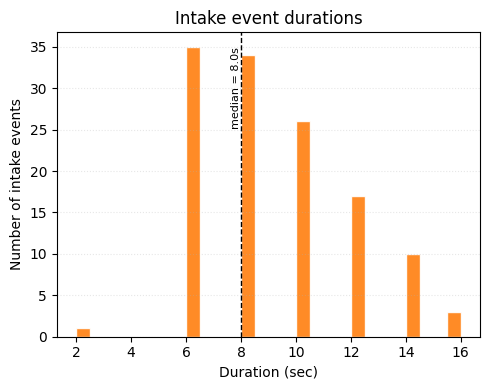

In [ ]:
# Bins selection:
bins_intake = np.arange(2.0, max(intake_dur.max(), 5.0) + 0.5, 0.5)

fig, ax = plt.subplots(figsize=(5, 4))

ax.hist(intake_dur, bins=bins_intake,
        color="tab:orange", edgecolor="white", alpha=0.9)

ax.set_title("Intake event durations", fontsize=12)
ax.set_xlabel("Duration (sec)", fontsize=10)
ax.set_ylabel("Number of intake events", fontsize=10)
ax.grid(axis="y", alpha=0.3, linestyle=":")

median_int = np.median(intake_dur)
ax.axvline(median_int, color="black", linestyle="--", linewidth=1)
ax.text(median_int, ax.get_ylim()[1]*0.95,
        f"median = {median_int:.1f}s",
        rotation=90, va="top", ha="right", fontsize=8)

plt.tight_layout()
plt.show()


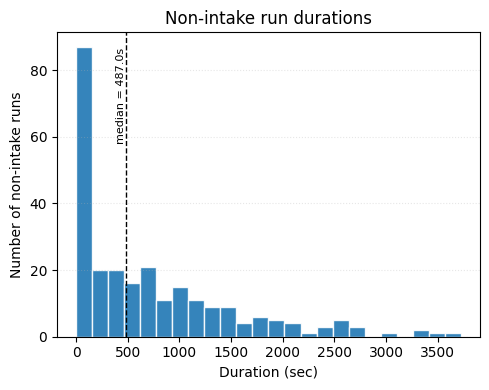

In [ ]:
# Bins selection:
p99 = np.percentile(non_dur, 99)
bins_non = np.linspace(0, p99, 25)

fig, ax = plt.subplots(figsize=(5, 4))

ax.hist(non_dur, bins=bins_non,
        color="tab:blue", edgecolor="white", alpha=0.9)

ax.set_title("Non-intake run durations", fontsize=12)
ax.set_xlabel("Duration (sec)", fontsize=10)
ax.set_ylabel("Number of non-intake runs", fontsize=10)
ax.grid(axis="y", alpha=0.3, linestyle=":")

median_non = np.median(non_dur)
ax.axvline(median_non, color="black", linestyle="--", linewidth=1)
ax.text(median_non, ax.get_ylim()[1]*0.95,
        f"median = {median_non:.1f}s",
        rotation=90, va="top", ha="right", fontsize=8)

plt.tight_layout()
plt.show()


### **Noisy Poses: Shoulder-to-wrist distances Outliers**

In [ ]:
ROOT = Path("/content/drive/MyDrive/eatsense")
POSE2D_DIR = ROOT / "poses_true" / "True2D"
VIDEO_DIR  = ROOT / "rgb" / "deepfaked"

def parse_xy_series(series: pd.Series) -> np.ndarray:
    """'(x, y)' -> float array (N, 2)."""
    xy = (
        series.astype(str)
              .str.strip().str.strip("()")
              .str.split(",", n=1, expand=True)
              .astype(float)
              .to_numpy()
    )
    return xy

def compute_dist_stats(csv_path: Path):
    """Return per-video limb distance stats + the per-frame distances."""
    df = pd.read_csv(csv_path)

    rw_xy = parse_xy_series(df["Right-Wrist"])
    lw_xy = parse_xy_series(df["Left-Wrist"])
    rs_xy = parse_xy_series(df["Right-Shoulder"])
    ls_xy = parse_xy_series(df["Left-shoulder"])

    dist_r = np.linalg.norm(rw_xy - rs_xy, axis=1)
    dist_l = np.linalg.norm(lw_xy - ls_xy, axis=1)
    dist_max = np.maximum(dist_r, dist_l)

    median = float(np.median(dist_max))
    stats = {
        "n_frames": len(df),
        "median": median,
        "p95":  float(np.quantile(dist_max, 0.95)),
        "p99":  float(np.quantile(dist_max, 0.99)),
        "p995": float(np.quantile(dist_max, 0.995)),
        "max":  float(dist_max.max()),
        "frac_above_1.5x_med": float((dist_max > 1.5 * median).mean()),
    }
    return stats, dist_max


In [ ]:
rows = []
dist_cache = {}

for csv_path in sorted(POSE2D_DIR.glob("*.csv")):
    stats, dist_max = compute_dist_stats(csv_path)
    key = csv_path.stem.split(".")[0]
    stats["key"] = key
    rows.append(stats)
    dist_cache[key] = dist_max

summary_df = (
    pd.DataFrame(rows)
      .set_index("key")
      .sort_values("p995", ascending=False)
)

summary_df.head(10)


,n_frames,median,p95,p99,p995,max,frac_above_1.5x_med
key,,,,,,,
20230111_114640_preds_HigherHRNet,2308,118.688425,147.022538,199.848020,214.870539,223.237079,0.017331
20210714_125156,6451,172.580648,187.243916,192.446410,209.220124,282.852395,0.003255
20230111_114057_preds_HigherHRNet,2486,126.939053,189.096332,199.550701,204.385397,228.535144,0.043443
20220811_113712,5078,157.851911,186.619320,193.722415,194.948714,200.764666,0.000000
20221013_142709_preds_HigherHRNet,3020,179.136037,185.395749,188.833913,194.443380,219.820711,0.000000
20230111_115239_preds_HigherHRNet,2817,119.272736,160.285627,180.893962,190.488931,208.074677,0.010650
20221014_113751_preds_HigherHRNet,8606,164.237319,182.074399,187.267339,188.389024,189.784130,0.000000
20221013_131254_preds_HigherHRNet,9122,126.820497,178.977999,180.849253,181.606104,239.113160,0.003618
20221014_140942_preds_HigherHRNet,5082,133.450297,153.545539,174.547136,179.855542,188.151216,0.000000


So basically above list contains the Videos that has the most abnormal shoulder-to-wrist distances when compared to the population

In [ ]:
# Let's select the first video (top-1 outlier):
bad_key = summary_df.index[0]
dist_max = dist_cache[bad_key]

median = np.median(dist_max)
noisy_thresh = np.quantile(dist_max, 0.995)   # top 0.5% as noisy
noisy_idx_all = np.where(dist_max > noisy_thresh)[0]

clean_band = 0.10 * median                    # +/-10% around median
clean_mask = (dist_max > median - clean_band) & (dist_max < median + clean_band)
clean_idx_all = np.where(clean_mask)[0]

print("Video:", bad_key)
print("Noisy candidates:", noisy_idx_all[:20])
print("Clean candidates:", clean_idx_all[:20])

Video: 20230111_114640_preds_HigherHRNet
Noisy candidates: [ 646  647  648 1490 1491 1492 1493 1494 1495 1496 1497 1498]
Clean candidates: [10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29]


In [ ]:
# Helpers:
def load_frames(video_path: Path, indices):
    """Return dict {frame_idx: RGB frame} for the given frame indices."""
    indices = sorted(set(int(i) for i in indices))
    wanted = set(indices)
    frames = {}

    cap = cv2.VideoCapture(str(video_path))
    i = 0
    while cap.isOpened():
        ret, frame_bgr = cap.read()
        if not ret:
            break
        if i in wanted:
            frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
            frames[i] = frame_rgb
            if len(frames) == len(wanted):
                break
        i += 1
    cap.release()
    return frames


def overlay_pose_on_frame(img, pose2d_row):
    """Draw shoulder–elbow–wrist skeleton on a single RGB frame."""
    img_h, img_w = img.shape[:2]

    def parse_xy(s):
        x, y = parse_xy_series(pd.Series([s]))[0]
        return int(round(x)), int(round(y))

    joints = [
        "Right-Shoulder", "Right-Elbow", "Right-Wrist",
        "Left-shoulder", "Left-Elbow", "Left-Wrist",
    ]
    coords = {j: parse_xy(pose2d_row[j]) for j in joints}

    segs = [
        ("Right-Shoulder", "Right-Elbow"),
        ("Right-Elbow", "Right-Wrist"),
        ("Left-shoulder", "Left-Elbow"),
        ("Left-Elbow", "Left-Wrist"),
    ]

    out = img.copy()
    # lines
    for a, b in segs:
        cv2.line(out, coords[a], coords[b], (0, 255, 0), 4)
    # joints
    for xy in coords.values():
        cv2.circle(out, xy, 5, (255, 0, 0), -1)
    return out

# Load CSV and find matching anonymized video for bad_key:
csv_path = POSE2D_DIR / f"{bad_key}.csv"
pose2d = pd.read_csv(csv_path)
core_id = bad_key.split("_preds")[0].replace(".mp4", "")
pattern = f"*{core_id}*anonymized.mp4"
video_candidates = list(VIDEO_DIR.rglob(pattern))

print("Searching video with pattern:", pattern)
print("Candidates:", video_candidates)

if not video_candidates:
    raise FileNotFoundError(f"No anonymized video found for {core_id} under {VIDEO_DIR}")

video_path = video_candidates[0]
print("Using video:", video_path)

# Plot:
noisy_frames = noisy_idx_all[:4]
clean_frames = clean_idx_all[:4]

frames_dict = load_frames(video_path, np.concatenate([noisy_frames, clean_frames]))


Searching video with pattern: *20230111_114640*anonymized.mp4
Candidates: [PosixPath('/content/drive/MyDrive/eatsense/rgb/deepfaked/out_rgb_[20230111_114640]_anonymized.mp4')]
Using video: /content/drive/MyDrive/eatsense/rgb/deepfaked/out_rgb_[20230111_114640]_anonymized.mp4


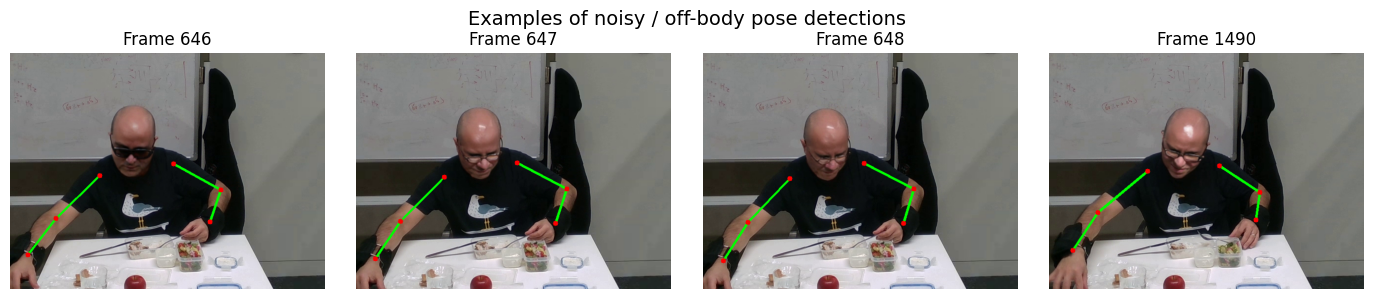

In [ ]:
fig, axes = plt.subplots(1, len(noisy_frames), figsize=(14, 3))
fig.suptitle("Examples of noisy / off-body pose detections", fontsize=14)

for ax, idx in zip(axes, noisy_frames):
    img = frames_dict[idx]
    img_pose = overlay_pose_on_frame(img, pose2d.iloc[idx])
    ax.imshow(img_pose)
    ax.set_axis_off()
    ax.set_title(f"Frame {idx}")

plt.tight_layout()
plt.show()


## **Label draft and timeline builder**

Alright, now that the True2D schema and the fast Parquet cache are done, I will sketch a first pass at labels. The goal is simple. For every video I will turn wrist and head coordinates into a light "phase" label per frame, then compress those into short segments we can visualize or learn from later.

* Keep the rules very simple: move hand towards mouth, eat it, move hand away from mouth.
* Compute wrist speed, wrist to head distance, and a tiny heuristic to decide the phase.
* Save both frame level labels and compressed segments to disk so the next notebooks can read them fast.

In [ ]:
OUT_LABELS = ROOT / "labels_v0"
OUT_LABELS.mkdir(parents=True, exist_ok=True)


In [ ]:
# alright now let's load one pose table by key:
def load_true2d_by_key(key: str) -> pd.DataFrame:
    p = (ROOT / "true2d_parquet" / f"{key}.parquet")
    if p.exists():
        return pd.read_parquet(p)
    row = manifest.loc[manifest["key"] == key].iloc[0]
    return load_true2d_pairwise_csv_with_fps(row["poses_true"], key, fps_by_key, default_fps=FPS_FALLBACK)

# here is a wrist speed helper:
def wrist_speed(px, py, t, win=5):
    vx = np.gradient(px, t)
    vy = np.gradient(py, t)
    v = np.hypot(vx, vy)
    if win and win > 1:
        v = np.convolve(v, np.ones(win)/win, mode="same")
    return v

# this is our simple phase rule:
def phase_labels(time, wx, wy, hx, hy, v, near_thr=45.0, slow_thr=60.0):
    d = np.hypot(wx - hx, wy - hy)
    dd = np.gradient(d, time)         # negative means moving closer
    labs = []
    for i in range(len(time)):
        if d[i] < near_thr and v[i] < slow_thr:
            labs.append("Eat it")
        elif dd[i] < 0:
            labs.append("Move hand towards mouth")
        else:
            labs.append("Move hand away from mouth")
    return labs

# finally, compress frame labels into segments:
def compress_segments(time, labels):
    out = []
    s = 0
    for i in range(1, len(labels)+1):
        if i == len(labels) or labels[i] != labels[s]:
            out.append((time[s], time[i-1], labels[s]))
            s = i
    return pd.DataFrame(out, columns=["start_sec","end_sec","label"])


In [ ]:
# pick one key to sanity check:
key = manifest.iloc[0]["key"]
df  = load_true2d_by_key(key)

# use right wrist by default:
t  = df["time_sec"].to_numpy()
wx = df["Right-Wrist_x"].to_numpy()
wy = df["Right-Wrist_y"].to_numpy()
hx = df["head_x"].to_numpy()
hy = df["head_y"].to_numpy()

v  = wrist_speed(wx, wy, t)
labs = phase_labels(t, wx, wy, hx, hy, v)

frame_labels = pd.DataFrame({"frame": df["frame"], "time_sec": t, "label": labs})
segments     = compress_segments(t, labs)

display(frame_labels.head(5))
display(segments.head(5))


,frame,time_sec,label
0,0,0.000000,Move hand towards mouth
1,1,0.066667,Move hand towards mouth
2,2,0.133333,Move hand towards mouth
3,3,0.200000,Move hand towards mouth
4,4,0.266667,Move hand towards mouth


,start_sec,end_sec,label
0,0.000000,1.133333,Move hand towards mouth
1,1.200000,1.266667,Move hand away from mouth
2,1.333333,1.400000,Move hand towards mouth
3,1.466667,2.066667,Move hand away from mouth
4,2.133333,2.133333,Move hand towards mouth


In [ ]:
# here I loop all keys, label, and save two files per video:
written_f, written_s = 0, 0

for key in manifest["key"]:
    df = load_true2d_by_key(key)

    t  = df["time_sec"].to_numpy()
    wx = df["Right-Wrist_x"].to_numpy()
    wy = df["Right-Wrist_y"].to_numpy()
    hx = df["head_x"].to_numpy()
    hy = df["head_y"].to_numpy()

    v  = wrist_speed(wx, wy, t)
    labs = phase_labels(t, wx, wy, hx, hy, v)

    frame_labels = pd.DataFrame({"frame": df["frame"], "time_sec": t, "label": labs})
    segments     = compress_segments(t, labs)

    frame_path = OUT_LABELS / f"{key}_frames.csv"
    segm_path  = OUT_LABELS / f"{key}_segments.csv"

    frame_labels.to_csv(frame_path, index=False)
    segments.to_csv(segm_path, index=False)

    written_f += 1
    written_s += 1

print("frame label files:", written_f)
print("segment files:", written_s)


frame label files: 135
segment files: 135


In [ ]:
have_f = sum((OUT_LABELS / f"{k}_frames.csv").exists()   for k in manifest["key"])
have_s = sum((OUT_LABELS / f"{k}_segments.csv").exists() for k in manifest["key"])
print(f"frames csv coverage: {have_f}/{len(manifest)}")
print(f"segments csv coverage: {have_s}/{len(manifest)}")


frames csv coverage: 135/135
segments csv coverage: 135/135


**Summary - what we have now:**

* A clean frame level label table for every video. columns are frame, time_sec, label.
* A tiny segment table for every video. columns are start_sec, end_sec, label.
* Files live under labels_v0 so we can iterate on the rule later without touching the Parquet cache.

## **Train, val, test split**

Alright, now that we have frame labels and segments for every video, let's freeze a simple split so later notebooks do not leak across groups. Since true participant ids are not in the file names we have, let's group by recording day using the date prefix in the key. This keeps clips from the same session together in one split.

* Group id: YYYYMMDD parsed from key like 20210518_230219
* Split ratio: 70 percent train, 15 percent val, 15 percent test.

In [ ]:
ROOT = Path("/content/drive/MyDrive/eatsense")
MANIFEST_CSV = ROOT / "manifest_eatsense.csv"

WINDOWS_FEATS = ROOT / "windows/pose_feats.parquet"

manifest = pd.read_csv(MANIFEST_CSV)

# Load window table:
windows_df = pd.read_parquet(WINDOWS_FEATS)
print("windows_df columns:", windows_df.columns)

if "label" not in windows_df.columns:
    if "y" in windows_df.columns:
        windows_df = windows_df.rename(columns={"y": "label"})
    else:
        raise ValueError("Could not find a label column; please check the column names above.")

windows_df["label"] = windows_df["label"].astype(int)

# Same group id as before:
def key_to_group(k: str) -> str:
    m = regex.match(r"(\d{8})_\d{6}", k)
    return m.group(1) if m else "unknown"

df_keys = manifest[["key"]].copy()
df_keys["group"] = df_keys["key"].map(key_to_group)

# Intake counts per key (and group) from windows_df:
pos_per_key = (
    windows_df.groupby("key")["label"]
    .sum()
    .rename("n_pos")
)

df_keys = df_keys.merge(pos_per_key, on="key", how="left")
df_keys["n_pos"] = df_keys["n_pos"].fillna(0).astype(int)

group_stats = (
    df_keys.groupby("group")["n_pos"]
    .sum()
    .reset_index()
)

groups   = group_stats["group"].to_numpy()
g_pos    = group_stats["n_pos"].to_numpy()
n_groups = len(groups)

total_pos    = g_pos.sum()
target_train = 0.70 * total_pos
target_val   = 0.15 * total_pos
target_test  = 0.15 * total_pos

n_train = int(0.70 * n_groups)
n_val   = int(0.15 * n_groups)

rng = np.random.RandomState(42)
best = None

for _ in range(5000):
    perm = rng.permutation(n_groups)
    idx_train = perm[:n_train]
    idx_val   = perm[n_train:n_train+n_val]
    idx_test  = perm[n_train+n_val:]

    pos_train = g_pos[idx_train].sum()
    pos_val   = g_pos[idx_val].sum()
    pos_test  = g_pos[idx_test].sum()

    score = (
        abs(pos_train - target_train) +
        abs(pos_val   - target_val) +
        abs(pos_test  - target_test)
    )

    if best is None or score < best[0]:
        best = (score, groups[idx_train], groups[idx_val], groups[idx_test])

best_score, train_g, val_g, test_g = best

print("Best score:", best_score)
print("Train groups:", len(train_g), "Val groups:", len(val_g),
      "Test groups:", len(test_g))

def assign_split(g):
    if g in train_g: return "train"
    if g in val_g:   return "val"
    return "test"

df_split = df_keys[["key", "group"]].copy()
df_split["split"] = df_split["group"].map(assign_split)

print(df_split["split"].value_counts())


windows_df columns: Index(['key', 'split', 'win_id', 'start_sec', 'end_sec', 'label',
       'rw_speed_mean', 'rw_speed_max', 'rw_head_min', 'rw_path',
       'lw_speed_mean', 'lw_speed_max', 'lw_head_min', 'lw_path',
       're_angle_mean', 're_angle_std', 'le_angle_mean', 'le_angle_std'],
      dtype='object')
Best score: 2.5999999999999943
Train groups: 29 Val groups: 6 Test groups: 7
split
train    82
test     29
val      22
Name: count, dtype: int64


In [ ]:
len(manifest), manifest["key"].nunique()


(133, 133)

In [ ]:
print(df_split.groupby("group")["split"].nunique().value_counts())

split
1    42
Name: count, dtype: int64


In [ ]:
train_keys = set(df_split.loc[df_split["split"] == "train", "key"])
val_keys   = set(df_split.loc[df_split["split"] == "val",   "key"])
test_keys  = set(df_split.loc[df_split["split"] == "test",  "key"])

print("train ∩ val:",  len(train_keys & val_keys))
print("train ∩ test:", len(train_keys & test_keys))
print("val   ∩ test:", len(val_keys   & test_keys))



train ∩ val: 0
train ∩ test: 0
val   ∩ test: 0


In [ ]:
# Drop any old split column so we only keep the new stratified one:
windows_df = windows_df.drop(columns=["split"], errors="ignore")

# Merge in the new split info:
windows_df = windows_df.merge(df_split[["key", "split"]], on="key", how="left")

# Sanity check:
print(windows_df.columns)



Index(['key', 'win_id', 'start_sec', 'end_sec', 'label', 'rw_speed_mean',
       'rw_speed_max', 'rw_head_min', 'rw_path', 'lw_speed_mean',
       'lw_speed_max', 'lw_head_min', 'lw_path', 're_angle_mean',
       're_angle_std', 'le_angle_mean', 'le_angle_std', 'split'],
      dtype='object')


In [ ]:
print(
    windows_df.groupby("split")["label"].agg(
        n_windows="count",
        n_pos="sum",
        pos_rate="mean",
    )
)




       n_windows  n_pos  pos_rate
split                            
test       22101     73  0.003303
train      57766    345  0.005972
val        17506     73  0.004170


## **Save the split mapping**

In [ ]:
ROOT = Path("/content/drive/MyDrive/eatsense")

# Key --> split map for 3D CNN:
KEY_SPLIT_PATH = ROOT / "labels_v1" / "key_split_v1.parquet"
df_split.to_parquet(KEY_SPLIT_PATH, index=False)
print("Saved key-level split map to:", KEY_SPLIT_PATH)

# Full window table with split: for pose TCN:
WINDOWS_WITH_SPLIT = ROOT / "windows" / "pose_feats_with_split_v1.parquet"
windows_df.to_parquet(WINDOWS_WITH_SPLIT, index=False)
print("Saved window-level table with split to:", WINDOWS_WITH_SPLIT)

Saved key-level split map to: /content/drive/MyDrive/eatsense/labels_v1/key_split_v1.parquet
Saved window-level table with split to: /content/drive/MyDrive/eatsense/windows/pose_feats_with_split_v1.parquet


In [ ]:
ROOT = Path("/content/drive/MyDrive/eatsense")
WINDOWS_NEW = ROOT / "windows/windows_pose_newsplit.parquet"

windows_df.to_parquet(WINDOWS_NEW)
print("Saved:", WINDOWS_NEW, "rows:", len(windows_df))
print(windows_df["split"].value_counts())

Saved: /content/drive/MyDrive/eatsense/windows/windows_pose_newsplit.parquet rows: 98582
split
train    57766
test     22101
val      17506
Name: count, dtype: int64
